# View Fors2 , View spectra one by one

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2022/12/23
- update : 2022/12/23
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

## Import

In [1]:
import os,sys,re
from astropy.io import fits
from astropy.table import Table

In [2]:
# Import some generally useful packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
from def_raw_seds import *

In [7]:
from raw_data_analysis import *

In [8]:
from spectroscopy import *

In [9]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [10]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

## Configuration

### Emission lines

In [11]:
df_lines=pd.read_excel("datatools/GalEmissionLines.xlsx")

In [12]:
df_lines

,wl,ion,Eiev,Ekev,Configurations,Terms,Ji - Jk,Type (if not E1),Creation IP (eV),Observation References,Note
0,770.409,Ne VIII,0.000,16.093,1s22s - 1s22p,2S - 2P0,1/2 - 3/2,NaN,207.27,Z97,NaN
1,780.324,Ne VIII,0.000,15.889,1s22s - 1s22p,2S - 2P0,1/2 - 1/2,NaN,207.27,Z97,NaN
2,937.814,Lyε,0.000,13.221,1s - 6,2S -,1/2 -,NaN,0.00,VB01,NaN
3,949.742,Lyδ,0.000,13.055,1s - 5,2S -,1/2 -,NaN,0.00,VB01,NaN
4,977.030,C III,0.000,12.690,1s22s2 - 1s22s2p,1S - 1P0,0 - 1,NaN,24.38,Z97,NaN
...,...,...,...,...,...,...,...,...,...,...,...
229,10320.490,[S II],1.845,3.046,3s23p3 - 3s23p3,2D0 - 2P0,2022-04-06 00:00:00,M1,10.36,OF96,NaN
230,10336.410,[S II],1.842,3.041,3s23p3 - 3s23p3,2D0 - 2P0,2022-02-04 00:00:00,M1,10.36,O90,NaN
231,10746.800,[Fe XIII],0.000,1.153,3s23p2 - 3s23p2,3P - 3P,0 - 1,M1,330.80,NaN,NaN
232,10830.340,He I,19.820,20.964,1s2s - 1s2p,3S - 3P0,2022-02-01 00:00:00,NaN,0.00,OF96,NaN


In [13]:
df_sdss_lines = pd.read_excel("datatools/sdss_galaxylines.xlsx")

In [14]:
df_sdss_lines

,wl,galaxy_weight,quasar_weight,species
0,1033.820,0.0,1.0,O VI
1,1215.240,0.0,9.0,Ly_alpha
2,1240.810,0.0,3.0,N V
3,1305.530,0.0,0.0,O I
4,1335.310,0.0,0.0,C II
5,1397.610,0.0,0.0,Si IV
6,1399.800,0.0,1.0,Si IV + O IV
7,1549.480,0.0,8.0,C IV
8,1640.400,0.0,0.0,He II
9,1665.850,0.0,0.0,O III


# Lines

In [15]:
lines_to_plot={}

In [16]:
def plot_line(ax,line_name):
    
    #keys = lines_to_plot.keys()
    #for the_key in keys:
    #    if the_key in line_name:
    #        print("the_key=",the_key," line_name=",line_name)
    #        line_name=the_key
    #        break
            
    posx0=0.0
    posy0=0.05
    fontsize=12
    the_color = {"emission":'r',"absorption":"g","break":"purple"}
    the_line_to_plot = lines_to_plot[line_name]
    wls = the_line_to_plot["wls"]
    tag = the_line_to_plot["name"]
    typ = the_line_to_plot["type"]
    
    xlim = ax.get_xlim()
    for wl in wls:
        ax.axvline(wl, lw=2, color=the_color[typ])
        xpos = (wl - xlim[0]) / (xlim[1] - xlim[0])+posx0 
        if 0 < xpos < 1:
            ax.annotate(tag, xy=(xpos, posy0), rotation=0, ha='left', va='bottom',
                            xycoords='axes fraction', color=the_color[typ], fontsize=fontsize)
    return ax

In [17]:
sel = df_sdss_lines["species"] == 'K'
wls = df_sdss_lines[sel]["wl"].values
Kline = Line(wls, atmospheric=False, label='$K$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["K"]={"wls":wls,"name":"K","type":"absorption"}

In [18]:
sel = df_sdss_lines["species"] == 'H'
wls = df_sdss_lines[sel]["wl"].values
Hline = Line(wls, atmospheric=False, label='$H$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["H"]={"wls":wls,"name":"H","type":"absorption"}

In [19]:
sel = df_sdss_lines["species"] == 'G'
wls = df_sdss_lines[sel]["wl"].values
Gline = Line(wls, atmospheric=False, label='$G$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["G"]={"wls":wls,"name":"G","type":"absorption"}

In [20]:
sel = df_sdss_lines["species"] == 'Mg'
wls = df_sdss_lines[sel]["wl"].values
Gline = Line(wls, atmospheric=False, label='$Mg$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["Mg"]={"wls":wls,"name":"Mg","type":"absorption"}

In [21]:
sel = df_sdss_lines["species"] == 'Na'
wls = df_sdss_lines[sel]["wl"].values
Gline = Line(wls, atmospheric=False, label='$Na$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["Na"]={"wls":wls,"name":"Na","type":"absorption"}

In [22]:
sel = df_lines["ion"] == 'H8'
wls = df_lines[sel]["wl"].values
H8line = Line(wls, atmospheric=False, label='$H8$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["H8"]={"wls":wls,"name":"$H8$","type":"emission"}

In [23]:
sel = df_lines["ion"] == 'H9'
wls = df_lines[sel]["wl"].values
H9line = Line(wls, atmospheric=False, label='$H9$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["H9"]={"wls":wls,"name":"$H9$","type":"emission"}

In [24]:
sel = df_lines["ion"] == 'H10'
wls = df_lines[sel]["wl"].values
H10line = Line(wls, atmospheric=False, label='$H10$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["H10"]={"wls":wls,"name":"$H10$","type":"emission"}

In [25]:
sel = df_lines["ion"] == 'H11'
wls = df_lines[sel]["wl"].values
lines_to_plot["H11"]={"wls":wls,"name":"$H11$","type":"emission"}

In [26]:
sel = df_lines["ion"] == 'Hα' 
wls=df_lines[sel]["wl"].values
Halphaline = Line(wls, atmospheric=False, label='$H_\\alpha$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["H{alpha}"]={"wls":wls,"name":"$H_\\alpha$","type":"emission"}

In [27]:
sel = df_lines["ion"] == 'Hβ' 
wls=df_lines[sel]["wl"].values
Hbetaline = Line(wls, atmospheric=False, label='$H_\\beta$', label_pos=[-0.04, 0.02], use_for_calibration=False)
lines_to_plot["H{beta}"]={"wls":wls,"name":"$H_\\beta$","type":"emission"}

In [28]:
sel = df_lines["ion"] == 'Hγ' 
wls=df_lines[sel]["wl"].values
lines_to_plot["H{gamma}"]={"wls":wls,"name":"$H_\\gamma$","type":"emission"}

In [29]:
sel = df_lines["ion"] == 'Hδ' 
wls=df_lines[sel]["wl"].values
lines_to_plot["H{delta}"]={"wls":wls,"name":"$H_\\delta$","type":"emission"}

In [30]:
sel = df_lines["ion"] == 'Hε' 
wls=df_lines[sel]["wl"].values
lines_to_plot["H{epsilon}"]={"wls":wls,"name":"$H_\\epsilon$","type":"emission"}

In [31]:
sel = df_lines["ion"] == '[O II]'
wls=df_lines[sel]["wl"].values
lines_to_plot["[OII]"]={"wls":wls,"name":"$[OII]$","type":"emission"}

In [32]:
sel = df_lines["ion"] == '[O III]'
wls=df_lines[sel]["wl"].values
lines_to_plot["[OIII]"]={"wls":wls,"name":"$[OIII]$","type":"emission"}

In [33]:
sel = df_lines["ion"] == 'O IV]'
wls=df_lines[sel]["wl"].values
lines_to_plot["[OIV]"]={"wls":wls,"name":"$[OIV]$","type":"emission"}

In [34]:
sel = df_lines["ion"] == 'O VI'
wls=df_lines[sel]["wl"].values
lines_to_plot["[OVI]"]={"wls":wls,"name":"$[OVI]$","type":"emission"}

In [35]:
sel = df_lines["ion"] == 'Mgb'
wls=df_lines[sel]["wl"].values
lines_to_plot["Mgb"]={"wls":wls,"name":"$Mgb$","type":"emission"}

In [36]:
sel = df_lines["ion"] == 'Mg II]'
wls=df_lines[sel]["wl"].values
lines_to_plot["MgII"]={"wls":wls,"name":"$MgII$","type":"emission"}

In [37]:
sel = df_lines["ion"] == 'Fe43'
wls=df_lines[sel]["wl"].values
lines_to_plot["Fe43"]={"wls":wls,"name":"$Fe43$","type":"emission"}

In [38]:
sel = df_lines["ion"] == 'Fe45'
wls=df_lines[sel]["wl"].values
lines_to_plot["Fe45"]={"wls":wls,"name":"$Fe45$","type":"emission"}

In [39]:
sel = df_lines["ion"] == 'Ca44'
wls=df_lines[sel]["wl"].values
lines_to_plot["Ca44"]={"wls":wls,"name":"$Ca44$","type":"emission"}

In [40]:
sel = df_lines["ion"] == 'E'
wls=df_lines[sel]["wl"].values
lines_to_plot["E"]={"wls":wls,"name":"$E$","type":"emission"}

In [41]:
sel = df_lines["ion"] =='Fe II'
wls=df_lines[sel]["wl"].values
lines_to_plot["FeII24"]={"wls":wls,"name":"$FeII24$","type":"emission"}
lines_to_plot['FeII26']={"wls":wls,"name":"$FeII26$","type":"emission"}

In [42]:
lines_to_plot['weak']={"wls":[],"name":"$weak$","type":"break"}
lines_to_plot['?']={"wls":[],"name":"$?$","type":"break"}

In [43]:
lines_to_plot['4000{AA}-break']={"wls":[4000.],"name":"$Bal$","type":"break"}

In [44]:
sel = df_lines["ion"] == 'Lyα'
wls=df_lines[sel]["wl"].values
lines_to_plot["Ly{alpha}"]={"wls":wls,"name":"$Ly_\\alpha$","type":"emission"}

In [45]:
sel = df_lines["ion"] == 'Lyβ'
wls=df_lines[sel]["wl"].values
lines_to_plot["Ly{beta}"]={"wls":wls,"name":"$Ly_\\beta$","type":"emission"}

In [46]:
sel = df_lines["ion"] == 'Lyδ'
wls=df_lines[sel]["wl"].values
lines_to_plot["Ly{delta}"]={"wls":wls,"name":"$Ly_\\delta$","type":"emission"}

In [47]:
sel = df_lines["ion"] == 'Lyε'
wls=df_lines[sel]["wl"].values
lines_to_plot["Ly{epsilon}"]={"wls":wls,"name":"$Ly_\\epsilon$","type":"emission"}

In [48]:
sel = df_lines["ion"] == 'C IV'
wls=df_lines[sel]["wl"].values
lines_to_plot["CIV"]={"wls":wls,"name":"$CIV$","type":"emission"}

In [49]:
sel = df_lines["ion"] == 'Al III'
wls=df_lines[sel]["wl"].values
lines_to_plot["AlIII"]={"wls":wls,"name":"$AlIII$","type":"emission"}

In [50]:
sel = df_lines["ion"] == '[Ne III]'
wls=df_lines[sel]["wl"].values
lines_to_plot['NeIII']={"wls":wls,"name":"$NeIII$","type":"emission"}

In [51]:
sel = df_lines["ion"] == 'He I'
wls=df_lines[sel]["wl"].values
lines_to_plot['HeI']={"wls":wls,"name":"$HeI$","type":"emission"}

In [52]:
sel = df_lines["ion"] == 'N III'
wls=df_lines[sel]["wl"].values
lines_to_plot['NIII']={"wls":wls,"name":"$NIII$","type":"emission"}

In [53]:
sel = df_lines["ion"] == 'Al II'
wls=df_lines[sel]["wl"].values
lines_to_plot['AlII']={"wls":wls,"name":"$AlII$","type":"emission"}

In [54]:
sel = df_lines["ion"] == 'Al III'
wls=df_lines[sel]["wl"].values
lines_to_plot['AlIII']={"wls":wls,"name":"$AlIII$","type":"emission"}

In [55]:
sel = df_lines["ion"] == '[N II]'
wls=df_lines[sel]["wl"].values
lines_to_plot['NII']={"wls":wls,"name":"$NII$","type":"emission"}

In [56]:
sel = df_lines["ion"] == 'C III'
wls=df_lines[sel]["wl"].values
lines_to_plot['CIII']={"wls":wls,"name":"$CIII$","type":"emission"}

In [57]:
sel = df_lines["ion"] == 'C IV'
wls=df_lines[sel]["wl"].values
lines_to_plot['CIV']={"wls":wls,"name":"$CIV$","type":"emission"}

In [58]:
sel = df_sdss_lines["species"] == 'Si IV + O IV'
wls=df_sdss_lines[sel]["wl"].values
lines_to_plot['SiIV/OIV']={"wls":wls,"name":"$SiIV/OIV$","type":"emission"}

In [59]:
lines_to_plot["(QSO)"] = {"wls":[],"name":"$QSO$","type":"emission"}
lines_to_plot["QSO"] = {"wls":[],"name":"$QSO$","type":"emission"}

In [60]:
lines_to_plot['NaD'] = {"wls":[],"name":"$NaD$","type":"emission"}

In [61]:
lines_to_plot['broad'] = {"wls":[],"name":"$broad$","type":"emission"}

In [62]:
lines_to_plot

{'K': {'wls': array([3934.777]), 'name': 'K', 'type': 'absorption'},
 'H': {'wls': array([4102.89 , 4341.68 , 4862.68 , 6564.61 , 3969.588]),
  'name': 'H',
  'type': 'absorption'},
 'G': {'wls': array([4305.61]), 'name': 'G', 'type': 'absorption'},
 'Mg': {'wls': array([5176.7]), 'name': 'Mg', 'type': 'absorption'},
 'Na': {'wls': array([5895.6]), 'name': 'Na', 'type': 'absorption'},
 'H8': {'wls': array([3889.064]), 'name': '$H8$', 'type': 'emission'},
 'H9': {'wls': array([3835.391]), 'name': '$H9$', 'type': 'emission'},
 'H10': {'wls': array([3797.904]), 'name': '$H10$', 'type': 'emission'},
 'H11': {'wls': array([3770.637]), 'name': '$H11$', 'type': 'emission'},
 'H{alpha}': {'wls': array([6562.819]),
  'name': '$H_\\alpha$',
  'type': 'emission'},
 'H{beta}': {'wls': array([4861.333]),
  'name': '$H_\\beta$',
  'type': 'emission'},
 'H{gamma}': {'wls': array([4340.471]),
  'name': '$H_\\gamma$',
  'type': 'emission'},
 'H{delta}': {'wls': array([4101.742]),
  'name': '$H_\\delta$

### Fors2

## Start

### Catalog

In [63]:
t = Table.read(filename_fits_catalog)

/Users/dagoret/anaconda3/lib/python3.9/site-packages/astropy/io/fits/connect.py:235: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


In [64]:
t

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
1,,13.52815,-28.40486,0.55409,,20.79,166227,55,10.0,1,"[OII],H8,K,H"
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"
4,,13.52216,-28.40914,0.68653,,21.62,205959,123,10.6,1,"[OII],H9,K,H,G,H{beta}"
7,,13.50974,-28.42972,0.32371,,22.34,97111,11,16.7,6,"[OII],H{beta},[OIII],H{alpha}"
9,,13.50219,-28.40641,0.29266,,21.6,87798,58,13.1,1,"H9,H8,K,H"
11,,13.49724,-28.39487,0.62688,,22.09,188063,17,24.3,3,"[OII],H10,H8,K,H,H{delta}"
12,,13.49584,-28.39125,0.2973,,21.97,89189,30,14.8,2,"[OII],H10,H9,H8,K,H"


### List

In [65]:
lst=fors2_jct_SL() #remet les spectres dans le rest frame (ie a z=0)

In [66]:
lst = sorted(lst)
print(lst)

['SPEC102', 'SPEC106', 'SPEC107', 'SPEC109', 'SPEC110', 'SPEC111', 'SPEC112', 'SPEC113', 'SPEC114', 'SPEC115', 'SPEC117', 'SPEC118', 'SPEC120', 'SPEC121', 'SPEC123', 'SPEC127', 'SPEC128', 'SPEC13', 'SPEC132', 'SPEC134', 'SPEC135', 'SPEC137', 'SPEC138', 'SPEC141', 'SPEC149', 'SPEC151', 'SPEC152', 'SPEC156', 'SPEC160', 'SPEC161', 'SPEC164', 'SPEC171', 'SPEC178', 'SPEC179', 'SPEC181', 'SPEC182', 'SPEC183', 'SPEC184', 'SPEC185', 'SPEC186', 'SPEC187', 'SPEC188', 'SPEC189', 'SPEC19', 'SPEC191', 'SPEC192', 'SPEC193', 'SPEC194', 'SPEC196', 'SPEC197', 'SPEC198', 'SPEC2', 'SPEC204', 'SPEC205', 'SPEC210', 'SPEC214', 'SPEC218', 'SPEC221', 'SPEC222', 'SPEC223', 'SPEC226', 'SPEC227', 'SPEC231', 'SPEC233', 'SPEC234', 'SPEC235', 'SPEC236', 'SPEC237', 'SPEC238', 'SPEC24', 'SPEC240', 'SPEC242', 'SPEC243', 'SPEC244', 'SPEC245', 'SPEC246', 'SPEC248', 'SPEC249', 'SPEC25', 'SPEC250', 'SPEC252', 'SPEC253', 'SPEC258', 'SPEC259', 'SPEC260', 'SPEC261', 'SPEC262', 'SPEC264', 'SPEC265', 'SPEC266', 'SPEC267', 'SPE

In [67]:
all_specfilenames = os.listdir(path_out_jct)

In [68]:
all_specfilenames = sorted(all_specfilenames)

In [69]:
all_numbers = [ int(re.findall('^SPEC(.*)[.]txt$',fn)[0]) for fn in all_specfilenames ]

In [70]:
all_numbers = sorted(all_numbers)

In [71]:
print(all_numbers)

[2, 3, 9, 13, 19, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 45, 47, 49, 51, 55, 57, 58, 59, 61, 62, 66, 67, 68, 69, 70, 71, 72, 73, 77, 79, 80, 83, 84, 85, 86, 87, 89, 91, 93, 96, 97, 102, 106, 107, 109, 110, 111, 112, 113, 114, 115, 117, 118, 120, 121, 123, 127, 128, 132, 134, 135, 137, 138, 141, 149, 151, 152, 156, 160, 161, 164, 171, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 198, 204, 205, 210, 214, 218, 221, 222, 223, 226, 227, 231, 233, 234, 235, 236, 237, 238, 240, 242, 243, 244, 245, 246, 248, 249, 250, 252, 253, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 271, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 287, 288, 291, 292, 294, 295, 296, 297, 298, 301, 302, 303, 304, 305, 306, 307, 308, 309, 313, 315, 317, 318, 319, 321, 322, 323, 324, 325, 326, 327, 328, 329, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 343, 344, 345, 346, 348, 349, 350, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367

In [72]:
NSED = len(all_numbers)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [73]:
cut = t["ID"] == 3
t[cut]

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"


In [74]:
t[cut]["z"].value[0]

0.6866

In [75]:
all_spectra = []
all_wl = []
all_tag = []
all_lines = []
#all_sed = []

for the_num in all_numbers:
    tcut = t["ID"] == the_num
    redshift = t[tcut]["z"].value[0]
    lines = t[tcut]["Lines"].value[0]
    filename = f"SPEC{the_num}.txt"
    tag = f"SPEC{the_num} , z={redshift:.2f}, lines={lines}"
    fullfilename = os.path.join(path_out_jct,filename)
#    the_sed=SED_jct(the_num)
#    all_sed.append(the_sed)
    arr = np.loadtxt(fullfilename)
    all_wl.append(arr[:,0])
    all_spectra.append(arr[:,1])
    all_tag.append(tag)
    all_lines.append(lines)
 

In [76]:
if 0:
    for idx in range(NSED):
        plt.figure(figsize=(16,2))
        plt.plot(all_wl[idx],all_spectra[idx], color=all_colors[idx],label=all_tag[idx])
        plt.legend(loc="upper right")
        plt.grid()
        plt.axvline(4150,color="k")
        plt.axvline(4250,color="k")
#    plt.ylim(-0.02,0.4)
        plt.xlim(2000.,8000.)
        plt.show()


the_lines =  b'                                                                            \r'



/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/2165024234.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


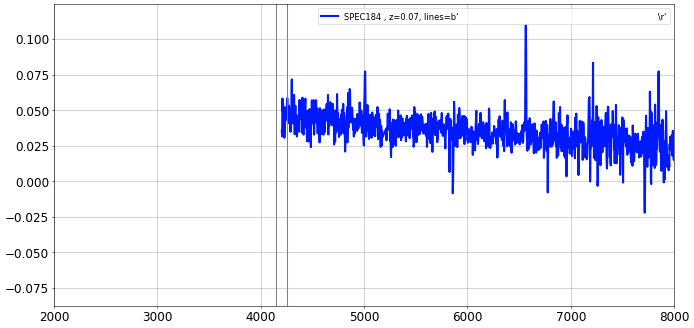

In [77]:
idx=82
the_lines = all_lines[idx]
print("the_lines = ",the_lines)
all_elements  = the_lines.decode().split(",")
#fig, ax = plt.subplot(1,1,1,figsize=(16,8))
fig, axs = plt.subplots(1, 1, figsize=(16, 8),dpi=50)
ax=axs
ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)
ax.legend(loc="upper right")
ax.grid()
ax.axvline(4150,color="grey")
ax.axvline(4250,color="grey")
#    plt.ylim(-0.02,0.4)
ax.set_xlim(2000.,8000.)
for el in all_elements:
    el=el.split(" ")[0]  
    print(el)
    if len(el)>0:
        plot_line(ax,el)


===================== SED 515 : SPEC702 , z=0.29, lines=b'[OII],H,H{beta},[OIII]                                                      \r'=======================
the_lines =  b'[OII],H,H{beta},[OIII]                                                      \r'


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


[OII]
H
H{beta}
[OIII]


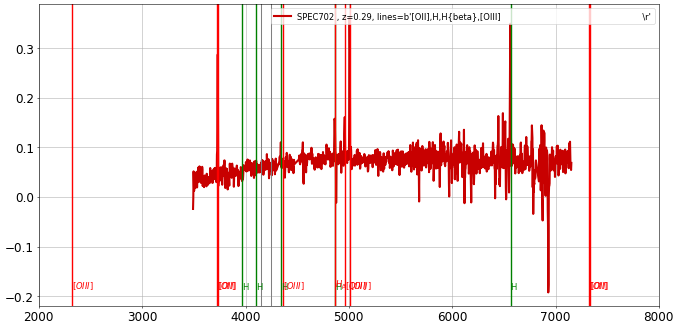

===================== SED 516 : SPEC703 , z=0.56, lines=b'[OII],K,H                                                                   \r'=======================
the_lines =  b'[OII],K,H                                                                   \r'
[OII]
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


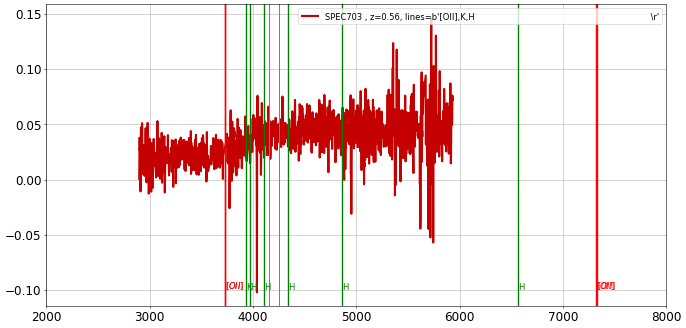

===================== SED 517 : SPEC704 , z=0.20, lines=b'H{beta},[OIII],H{alpha}                                                     \r'=======================
the_lines =  b'H{beta},[OIII],H{alpha}                                                     \r'
H{beta}
[OIII]


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


H{alpha}


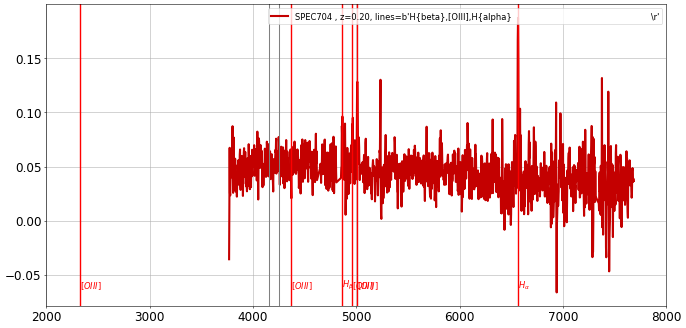

===================== SED 518 : SPEC705 , z=0.56, lines=b'K,H,4000{AA}-break                                                          \r'=======================
the_lines =  b'K,H,4000{AA}-break                                                          \r'
K
H
4000{AA}-break


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


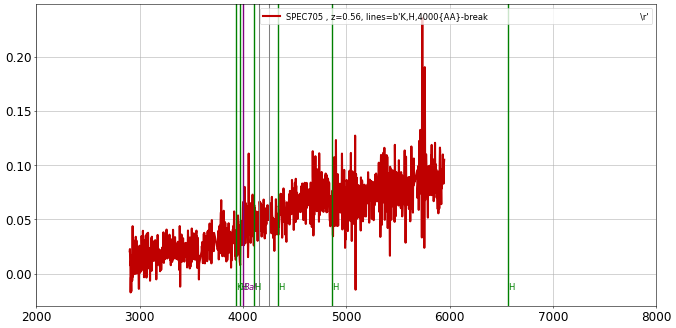

===================== SED 519 : SPEC706 , z=0.36, lines=b'weak,[OII],K,H,G                                                            \r'=======================
the_lines =  b'weak,[OII],K,H,G                                                            \r'
weak
[OII]
K
H
G


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


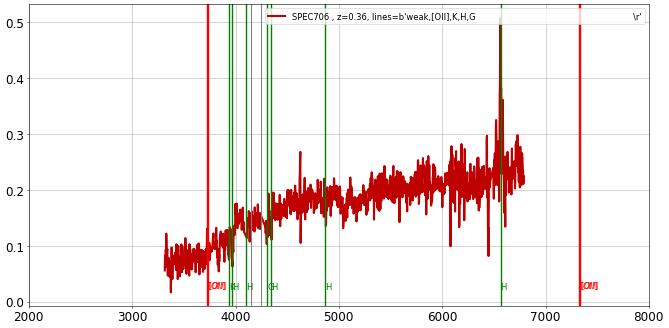

===================== SED 520 : SPEC707 , z=0.29, lines=b'[OII],H,[OIII]                                                              \r'=======================
the_lines =  b'[OII],H,[OIII]                                                              \r'


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


[OII]
H
[OIII]


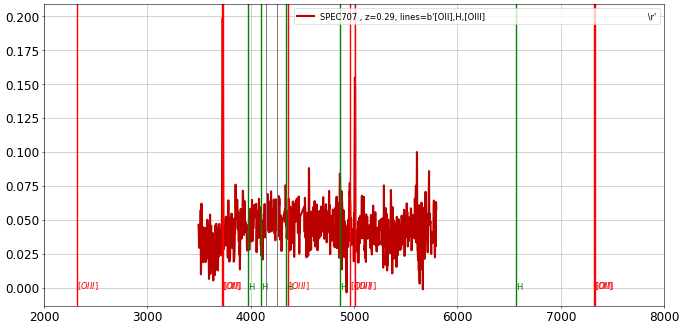

===================== SED 521 : SPEC708 , z=0.56, lines=b'[OII],H9,K,H                                                                \r'=======================
the_lines =  b'[OII],H9,K,H                                                                \r'
[OII]
H9
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


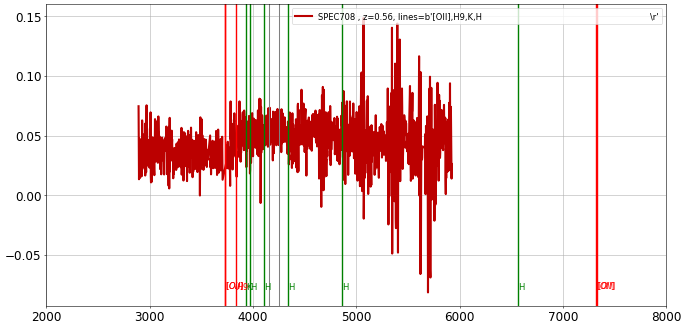

===================== SED 522 : SPEC710 , z=0.78, lines=b'MgII,[OII],H9,H8,H{gamma},H{beta}                                           \r'=======================
the_lines =  b'MgII,[OII],H9,H8,H{gamma},H{beta}                                           \r'
MgII
[OII]
H9
H8
H{gamma}
H{beta}

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


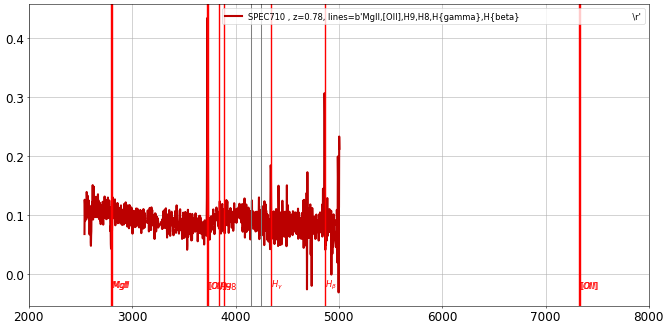

===================== SED 523 : SPEC711 , z=0.56, lines=b'K,H,4000{AA}-break                                                          \r'=======================
the_lines =  b'K,H,4000{AA}-break                                                          \r'
K
H
4000{AA}-break


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


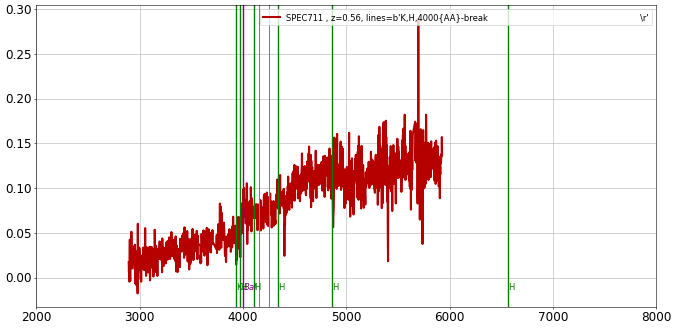

===================== SED 524 : SPEC713 , z=0.56, lines=b'[OII],H,H{delta},H{beta},[OIII]                                             \r'=======================
the_lines =  b'[OII],H,H{delta},H{beta},[OIII]                                             \r'


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


[OII]
H
H{delta}
H{beta}
[OIII]


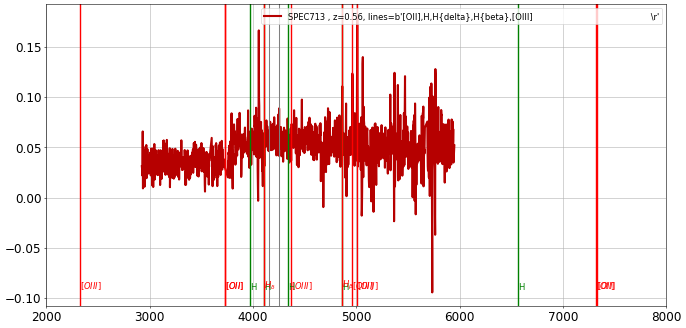

===================== SED 525 : SPEC714 , z=2.42, lines=b'QSO,SiIV/OIV,CIV,CIII                                                       \r'=======================
the_lines =  b'QSO,SiIV/OIV,CIV,CIII                                                       \r'
QSO
SiIV/OIV
CIV
CIII


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


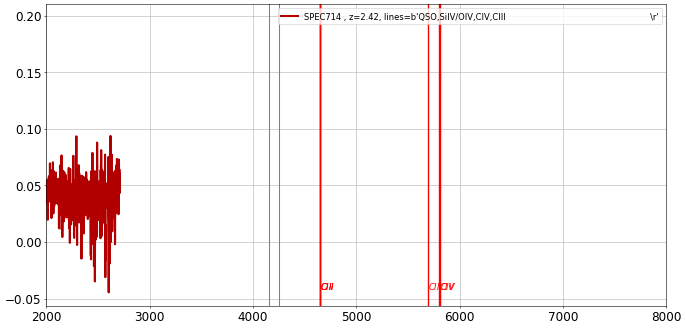

===================== SED 526 : SPEC715 , z=0.56, lines=b'[OII],H9,H8,K,H                                                             \r'=======================
the_lines =  b'[OII],H9,H8,K,H                                                             \r'
[OII]
H9
H8
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


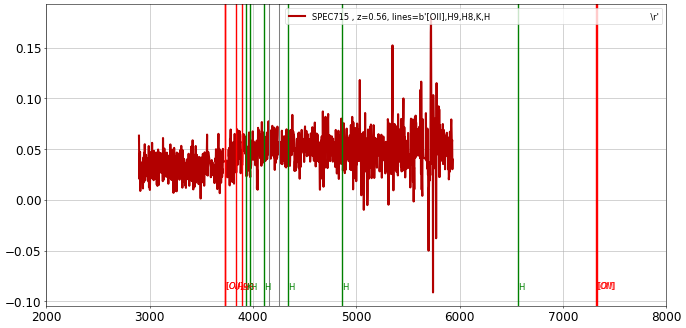

===================== SED 527 : SPEC716 , z=0.44, lines=b'[OII],K,H,4000{AA}-break                                                    \r'=======================
the_lines =  b'[OII],K,H,4000{AA}-break                                                    \r'


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


[OII]
K
H
4000{AA}-break


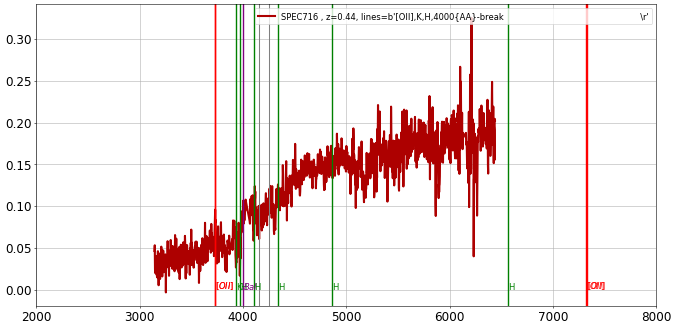

===================== SED 528 : SPEC717 , z=0.92, lines=b'[OII]                                                                       \r'=======================
the_lines =  b'[OII]                                                                       \r'
[OII]


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


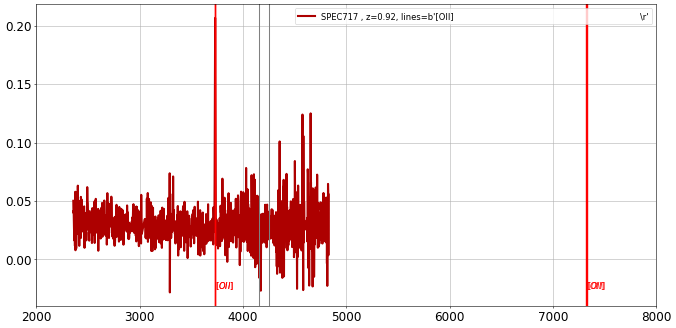

===================== SED 529 : SPEC718 , z=0.44, lines=b'K,H,G                                                                       \r'=======================
the_lines =  b'K,H,G                                                                       \r'
K
H
G


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


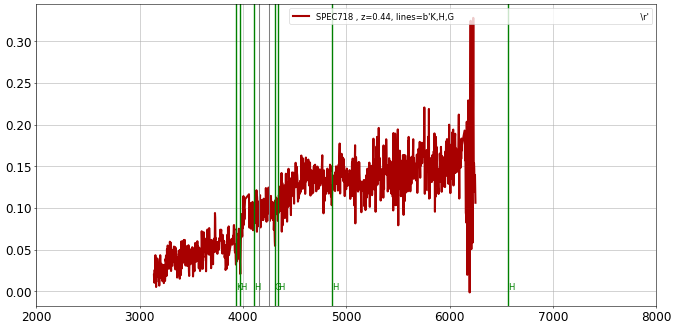

===================== SED 530 : SPEC719 , z=0.27, lines=b'[OII],H11,H10,H9,H8,K,H,H{delta},H{beta},[OIII],H{alpha}                    \r'=======================
the_lines =  b'[OII],H11,H10,H9,H8,K,H,H{delta},H{beta},[OIII],H{alpha}                    \r'
[OII]
H11
H10
H9
H8
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


H{delta}
H{beta}
[OIII]
H{alpha}


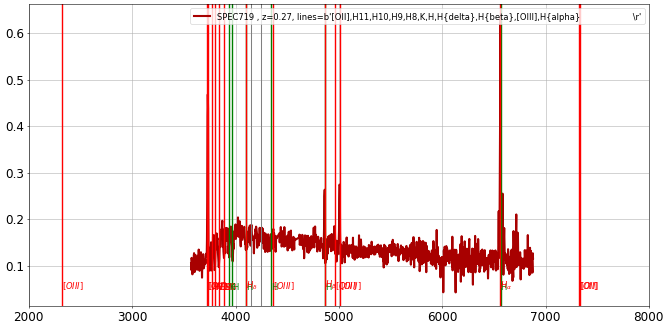

===================== SED 531 : SPEC720 , z=0.44, lines=b'[OII],K,H                                                                   \r'=======================
the_lines =  b'[OII],K,H                                                                   \r'
[OII]
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


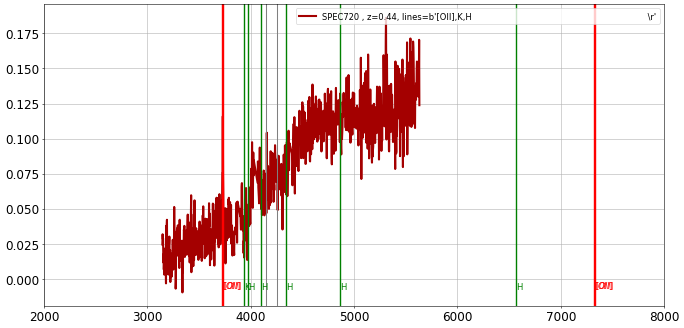

===================== SED 532 : SPEC721 , z=0.63, lines=b'K,H,4000{AA}-break,G                                                        \r'=======================
the_lines =  b'K,H,4000{AA}-break,G                                                        \r'


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


K
H
4000{AA}-break
G


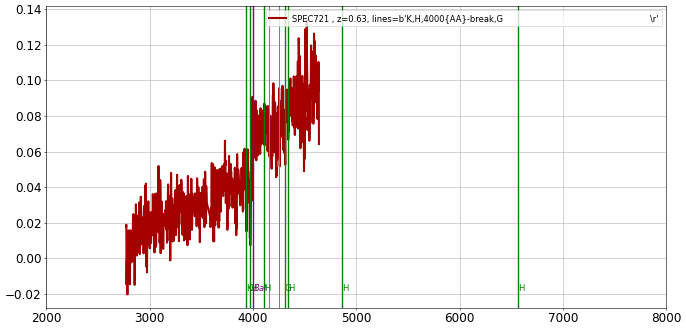

===================== SED 533 : SPEC722 , z=1.21, lines=b'broad,MgII,(QSO)                                                            \r'=======================
the_lines =  b'broad,MgII,(QSO)                                                            \r'
broad

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)



MgII
(QSO)


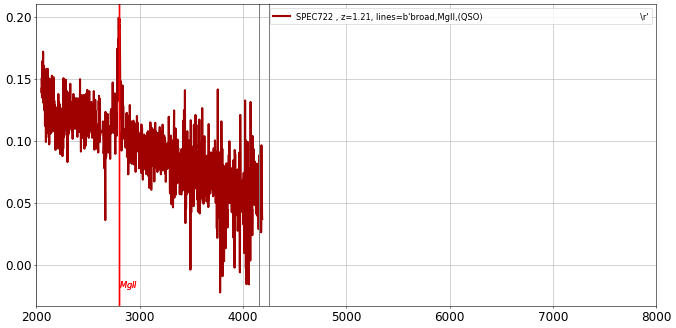

===================== SED 534 : SPEC723 , z=0.23, lines=b'[OII],H9,H8,K,H,H{delta},H{beta},[OIII],H{alpha}                            \r'=======================
the_lines =  b'[OII],H9,H8,K,H,H{delta},H{beta},[OIII],H{alpha}                            \r'
[OII]
H9
H8
K
H
H{delta}
H{beta}
[OIII]
H{alpha}


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


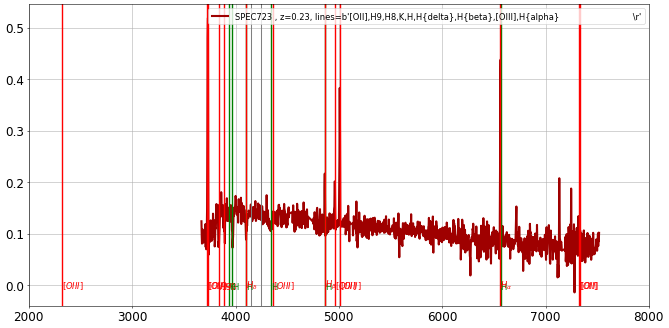

===================== SED 535 : SPEC724 , z=0.23, lines=b'[OII],H8,H,H{beta},[OIII],H{alpha}                                          \r'=======================
the_lines =  b'[OII],H8,H,H{beta},[OIII],H{alpha}                                          \r'
[OII]
H8
H
H{beta}
[OIII]
H{alpha}


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


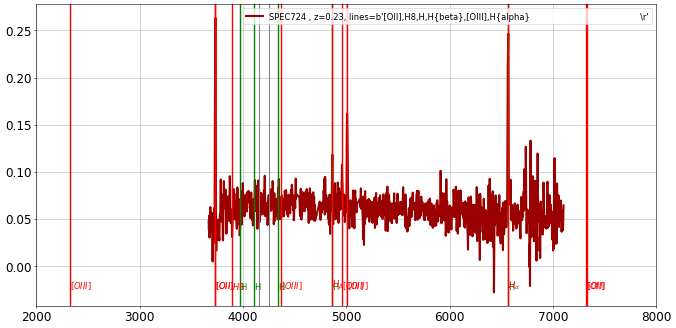

===================== SED 536 : SPEC725 , z=0.23, lines=b'[OII],H{beta},[OIII],H{alpha}                                               \r'=======================
the_lines =  b'[OII],H{beta},[OIII],H{alpha}                                               \r'
[OII]
H{beta}
[OIII]
H{alpha}


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


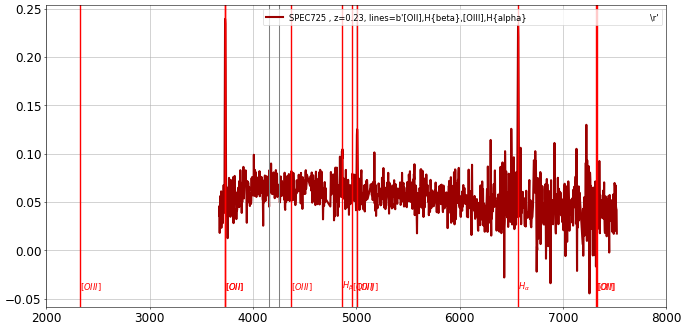

===================== SED 537 : SPEC726 , z=0.54, lines=b'weak,[OII],H9,K,H                                                           \r'=======================
the_lines =  b'weak,[OII],H9,K,H                                                           \r'
weak
[OII]
H9
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


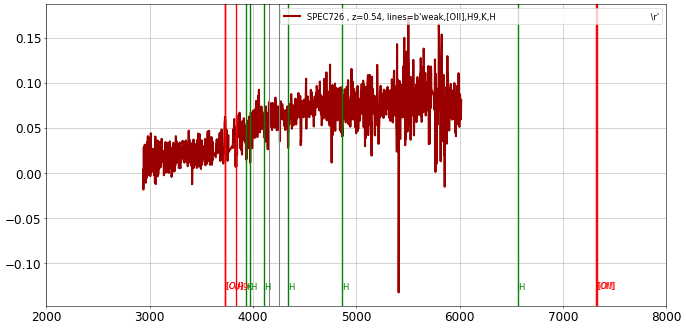

===================== SED 538 : SPEC727 , z=0.23, lines=b'[OII],[OIII],H{alpha}                                                       \r'=======================
the_lines =  b'[OII],[OIII],H{alpha}                                                       \r'
[OII]
[OIII]
H{alpha}


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


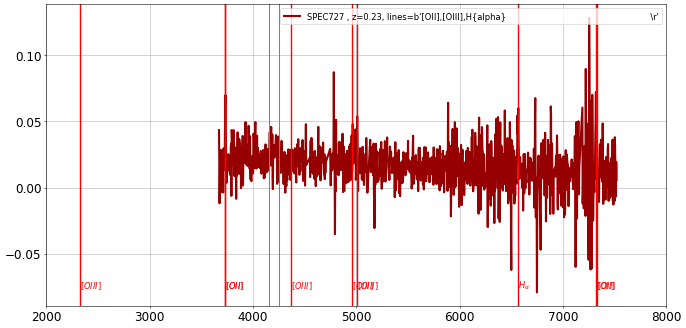

===================== SED 539 : SPEC728 , z=0.44, lines=b'[OII],H9,H8,K,H,H{beta}                                                     \r'=======================
the_lines =  b'[OII],H9,H8,K,H,H{beta}                                                     \r'
[OII]
H9
H8
K
H
H{beta}


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


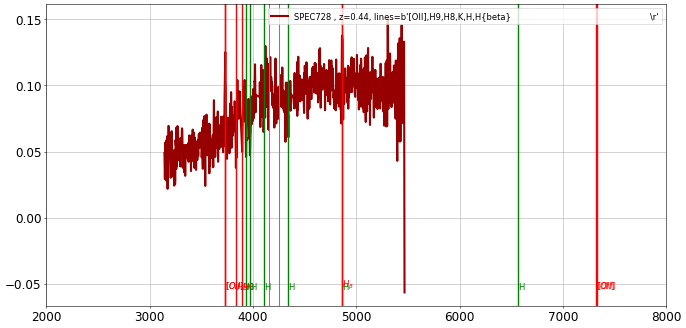

===================== SED 540 : SPEC729 , z=0.43, lines=b'[OII],H10,H9,K,H                                                            \r'=======================
the_lines =  b'[OII],H10,H9,K,H                                                            \r'
[OII]
H10
H9
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


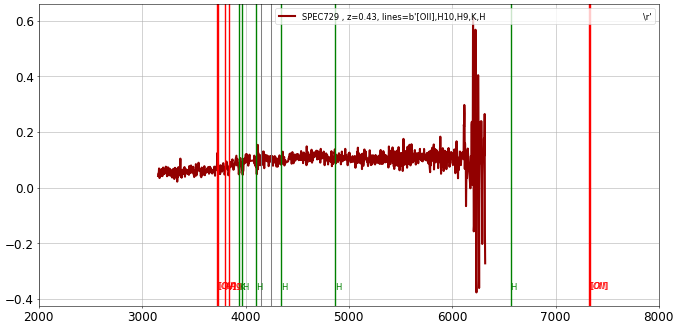

===================== SED 541 : SPEC730 , z=0.55, lines=b'[OII],H{gamma},H{beta},[OIII]                                               \r'=======================
the_lines =  b'[OII],H{gamma},H{beta},[OIII]                                               \r'
[OII]
H{gamma}
H{beta}
[OIII]


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


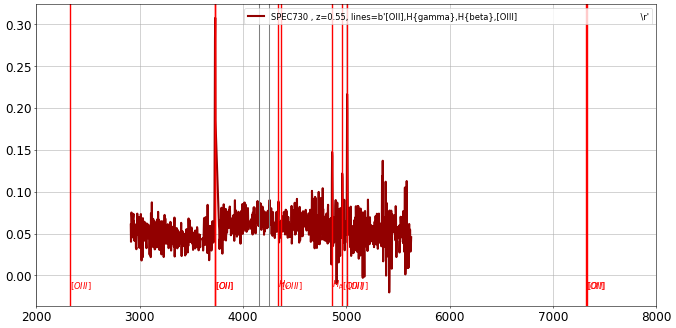

===================== SED 542 : SPEC731 , z=0.55, lines=b'weak,[OII],H9,H,4000{AA}-break                                              \r'=======================
the_lines =  b'weak,[OII],H9,H,4000{AA}-break                                              \r'
weak
[OII]
H9
H
4000{AA}-break


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


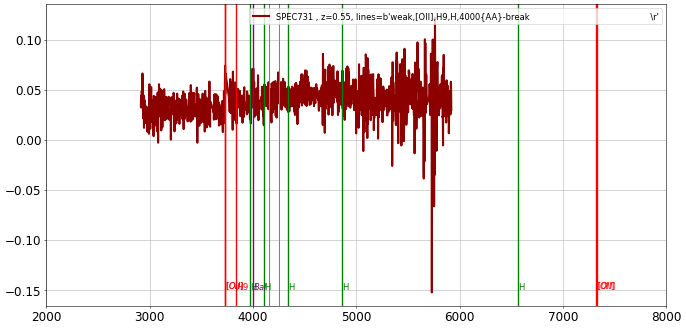

===================== SED 543 : SPEC732 , z=0.16, lines=b'H,K,H{gamma},H{beta},[OIII],H{alpha},NII                                    \r'=======================
the_lines =  b'H,K,H{gamma},H{beta},[OIII],H{alpha},NII                                    \r'
H
K
H{gamma}
H{beta}
[OIII]
H{alpha}
NII


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


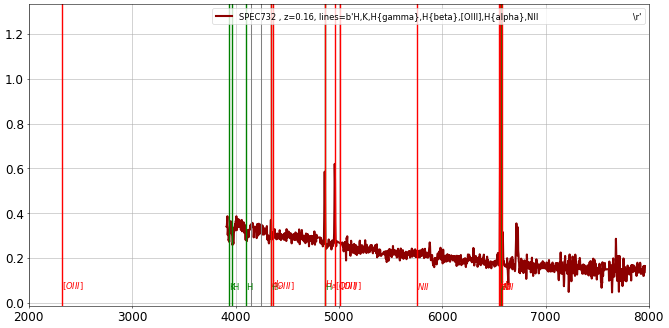

===================== SED 544 : SPEC733 , z=0.20, lines=b'K,H,H{beta},[OIII]                                                          \r'=======================
the_lines =  b'K,H,H{beta},[OIII]                                                          \r'
K
H
H{beta}
[OIII]


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


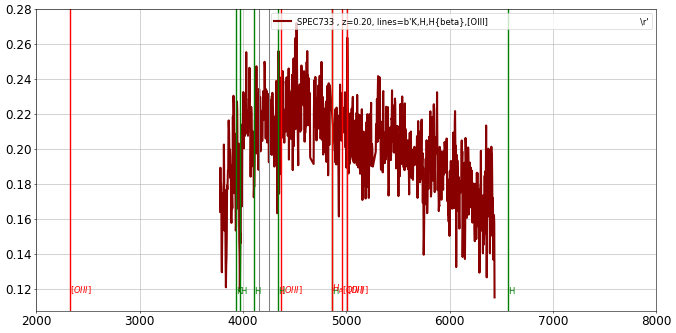

===================== SED 545 : SPEC734 , z=0.23, lines=b'[OII],H9,K,H,H{alpha},NII                                                   \r'=======================
the_lines =  b'[OII],H9,K,H,H{alpha},NII                                                   \r'
[OII]
H9
K
H
H{alpha}
NII


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


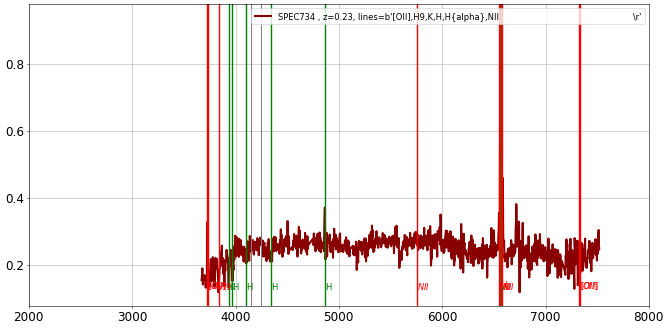

===================== SED 546 : SPEC735 , z=0.36, lines=b'K,H,G,H{beta}                                                               \r'=======================
the_lines =  b'K,H,G,H{beta}                                                               \r'
K
H
G
H{beta}


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


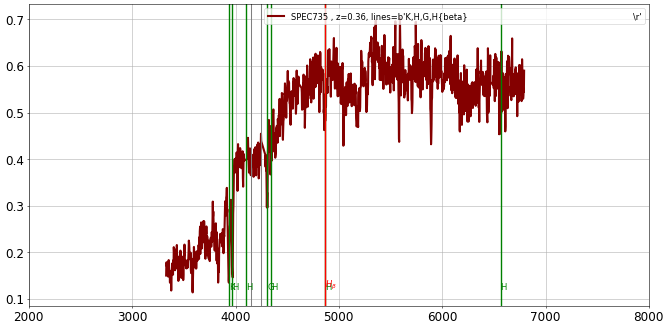

===================== SED 547 : SPEC736 , z=0.56, lines=b'[OII],H9,H{beta},[OIII]                                                     \r'=======================
the_lines =  b'[OII],H9,H{beta},[OIII]                                                     \r'
[OII]


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


H9
H{beta}
[OIII]


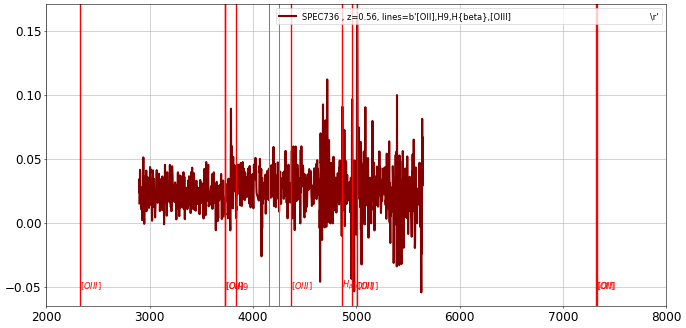

===================== SED 548 : SPEC737 , z=0.52, lines=b'[OII],K,H                                                                   \r'=======================
the_lines =  b'[OII],K,H                                                                   \r'
[OII]
K
H


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


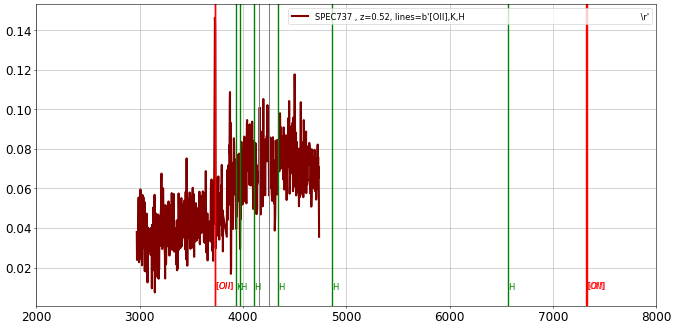

===================== SED 549 : SPEC738 , z=0.56, lines=b'K,H,4000{AA}-break,G                                                        \r'=======================
the_lines =  b'K,H,4000{AA}-break,G                                                        \r'
K
H
4000{AA}-break
G


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_27429/8400210.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)


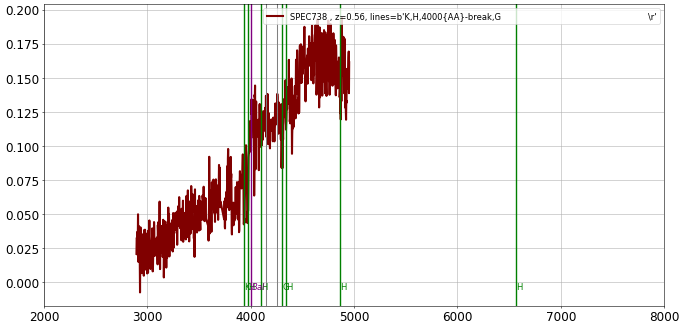

In [78]:
for idx in range(515,NSED):
    the_tag=all_tag[idx] 
    print(f"===================== SED {idx} : {the_tag}=======================")
    
    the_lines = all_lines[idx]
    print("the_lines = ",the_lines)
    all_elements  = the_lines.decode().split(",")
    #fig, ax = plt.subplot(1,1,1,figsize=(16,8))
    fig, axs = plt.subplots(1, 1, figsize=(16, 8),dpi=50)
    ax=axs
    ax.plot(all_wl[idx],all_spectra[idx],'b-' ,color=all_colors[idx],label=all_tag[idx],lw=3)
    ax.legend(loc="upper right")
    ax.grid()
    ax.axvline(4150,color="grey")
    ax.axvline(4250,color="grey")
#    plt.ylim(-0.02,0.4)
    ax.set_xlim(2000.,8000.)
    for el in all_elements:
        el=el.split(" ")[0]  
        el=el.split("\r")[0]  
        print(el)
        if len(el)>0:
            plot_line(ax,el)
    plt.show()
    
    

In [79]:
NSED

550